# Image Forensic Localization

In 2013 IEEE Information Forensics and Security Technical Committee (IFS-TC) established the First IFS-TC Image Forensics
Challenge

Image forgery localization is one of the most challenging
tasks in digital image forensics. Different from forgery
detection which simply discriminates whether a given image is pristine or fake, image forgery localization attempts
to detect the accurate tampered areas. Since forgery localization needs to conduct pixel-level analyses, it is more
difficult than the conventional forgery detection task.

**Fake image**: An image that has been manipulated/doctored using the two most common manipulation operations namely: copy/pasting and image splicing.

**Pristine image**: An image that has not been manipulated except for the resizing needed to bring all images to a standard size as per competition rules.

**Image splicing**: The splicing operations can combine images of people, adding doors to buildings, adding trees and cars to parking lots etc. The spliced images can also contain resulting parts from copy/pasting operations. The image receiving a spliced part is called a “host” image. The parts being spliced together with the host image are referred to as “aliens”

**Objective:**

Given images and their corresponding ground truths, we need to conduct pixel-level analyses to locate the accurate tampered areas.

**Dataset Overview:**

The dataset consists of 1050 pristine, 450 fake images and 450 Ground truths. Color images are usually 3 channel images one channel for each red, green and blue colors, however sometimes the fourth channel for yellow may be present. Images in our dataset are a mix of 1, 3 and 4 channel images.

In [0]:
# Download Data

#!wget --header="Host: uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.dropbox.com/" "https://uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com/cd/0/get/ApWvC8xO6eFpqm96OjQOtubLFyN-6JLpRmGBAGDlUYQKuFCh3v66ObS6fok_ek59M9cDYA2aO0CbtqeNrEWGAFg8Wt1AH6Z6LQRTU53pcSaHBQ/file?_download_id=8477232177633631706739485635867118070152572682347424645594964017&_notify_domain=www.dropbox.com&dl=1" -O "phase-01-training.tar.gz" -c

--2019-09-27 08:21:25--  https://uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com/cd/0/get/ApWvC8xO6eFpqm96OjQOtubLFyN-6JLpRmGBAGDlUYQKuFCh3v66ObS6fok_ek59M9cDYA2aO0CbtqeNrEWGAFg8Wt1AH6Z6LQRTU53pcSaHBQ/file?_download_id=8477232177633631706739485635867118070152572682347424645594964017&_notify_domain=www.dropbox.com&dl=1
Resolving uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com (uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601f:6::a27d:906
Connecting to uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com (uccb7c55f8c780cb4135c0e9af82.dl.dropboxusercontent.com)|162.125.9.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2749754446 (2.6G) [application/binary]
Saving to: ‘phase-01-training.tar.gz’

phase-01-training.t 100%[===================>]   2.56G  46.0MB/s    in 55s     

2019-09-27 08:22:22 (47.3 MB/s) - ‘phase-01-training.tar.gz’ saved [2749754446/2749754446]



In [0]:
# import tarfile
# tar = tarfile.open("/content/drive/My Drive/COLAB FILES/Image Forensics/phase-01-training.tar.gz")
# tar.extractall()
# tar.close()


# shutil.rmtree("/content/dataset-dist/phase-01/training/aug_data_512")

In [0]:
# root_path = '/content/drive/My Drive/COLAB FILES/Image Forensics'  #change dir to your project folder
# import os
# os.chdir(root_path)
# !ls

dataset-dist  phase-01-training.tar.gz	Task_2-Copy2.ipynb


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# https://github.com/qubvel/segmentation_models

# Segmentation models is python library with Neural Networks for Image Segmentation based on Keras and Tensorflow Keras frameworks.

!pip install segmentation-models

In [3]:
# Import Libraries 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
import tarfile
from PIL import Image
import matplotlib
from tqdm import tqdm_notebook, tnrange
from PIL import Image, ImageChops, ImageEnhance

from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam,SGD
from keras import optimizers
from tensorboardcolab import TensorBoardColab,TensorBoardColabCallback
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

from tqdm import tqdm
import cv2
import shutil

# https://github.com/albu/albumentations

'''from albumentations import (
    IAAPerspective, ShiftScaleRotate, CLAHE, 
     ShiftScaleRotate, Blur,   HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
	PadIfNeeded,HorizontalFlip,VerticalFlip, CenterCrop, Crop, Compose, Transpose, RandomRotate90, ElasticTransform, 
    GridDistortion, OpticalDistortion, RandomSizedCrop, OneOf, CLAHE, RandomBrightnessContrast, RandomGamma, ChannelShuffle,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, RGBShift, Rotate
)'''

from albumentations import *

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [0]:
# We have seperated forged images and its corresponding mask images.

pristine_dir='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/pristine/'
fake_dir='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/fake/'
#mask_dir='C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training_1/dataset-dist/phase-01/training/maskfiles/'
path ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'

len(os.listdir(pristine_dir)),len(os.listdir(fake_dir))

(1050, 900)

In [0]:
fake_images=list(os.listdir(fake_dir))
fake_image_ids=list(set([val[:32] for val in fake_images]))
len(fake_image_ids)

# fake_image_ids[0] - 'e3f10dc9b7dfcf91efd0bce8bf2c82b0'

450

In [0]:
pristine_imageIDs=[]
for file in os.listdir(pristine_dir):
    pristine_imageIDs.append(file)
pristine_imageIDs=[val[0:32] for val in pristine_imageIDs]

fake_imageIDs=[]
for file in os.listdir(fake_dir):
    fake_imageIDs.append(file)
fake_imageIDs=list(set([val[0:32] for val in fake_imageIDs]))

In [0]:
def mask_prestine(path):
    img = Image.open(path).convert("RGB")
    img_shape=(np.array(img)).shape
    return np.ones((img_shape))*255

def plot_Mask(image_id,fake=True):
    if fake:
        PATH='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/fake/'+image_id+'.png'
    else:
        PATH='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/pristine/'+image_id+'.png'

    PATH_mask=PATH[:-3]+'mask.png'
    img = Image.open(PATH).convert("RGB")
    try:
        mask_img=Image.open(PATH_mask).convert("RGB")
    except:
        mask_img=mask_prestine(PATH)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_title("Image")
    ax2.set_title("Mask")
    ax1.imshow(img)
    ax2.imshow(mask_img)
    print("image {0} has a shape of {1}".format(image_id,np.array(img).shape))
    print("image {0} has a shape of {1}".format(image_id,np.array(mask_img).shape))
    print("*"*60)

image d6388ee9f63e1111d41ce66ddf06ff41 has a shape of (3240, 4320, 3)
image d6388ee9f63e1111d41ce66ddf06ff41 has a shape of (3240, 4320, 3)
************************************************************


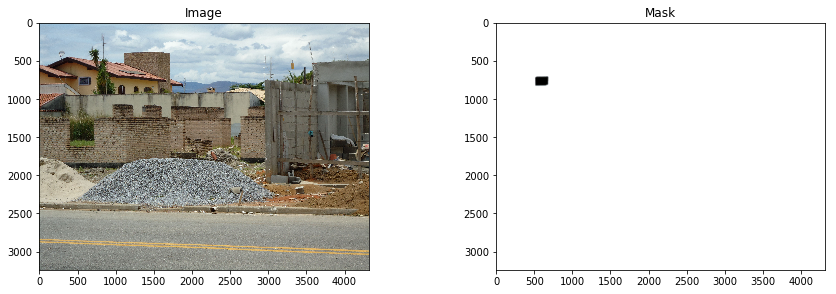

In [0]:
plot_Mask(fake_imageIDs[153])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 4bc6326fedd3e7cea3abf418c225d5df has a shape of (575, 1024, 3)
image 4bc6326fedd3e7cea3abf418c225d5df has a shape of (575, 1024, 3)
************************************************************


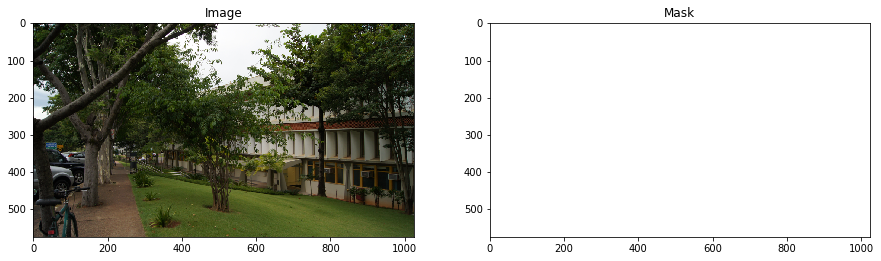

In [0]:
plot_Mask(pristine_imageIDs[153],fake=False)

### Processed Fake Images

In [0]:
%%time
if not os.path.exists(path+"total_images_512"):
    os.makedirs(path+"total_images_512/masks")
    os.makedirs(path+"total_images_512/images")
    for i,val in enumerate(fake_imageIDs):
        actual_image=fake_dir+val+".png"
        img=Image.open(actual_image).convert("RGB")
        image_id="image{}.png".format(i)
        height = 512
        width = 512
        img = img.resize((height, width), PIL.Image.ANTIALIAS)
        img.save(path+"total_images_512/images/"+image_id)
        #PATH_mask=PATH[:-3]+'mask.png'
        mask_image=val+".mask.png"
        mask=Image.open(fake_dir+mask_image).convert("RGB")
        #hpercent = (baseheight / float(mask.size[1]))
        #wsize = int((float(mask.size[0]) * float(hpercent)))
        mask = mask.resize((height, width), PIL.Image.ANTIALIAS)
        mask_id="mask{}.png".format(i)
        mask.save(path+"total_images_512/masks/"+mask_id)
    print("Done Resizing for fake images and masks")  
else:
    print("Directories are already present in the path")

Directories are already present in the path
CPU times: user 956 µs, sys: 334 µs, total: 1.29 ms
Wall time: 3.09 ms


### Processed Pristine Images

In [0]:
%%time
for i,val in enumerate(pristine_imageIDs):
    actual_image=pristine_dir+val+".png"
    img=Image.open(actual_image).convert("RGB")
    image_id="image{}.png".format(450+i)
    height = 512
    width = 512
    img = img.resize((height, width), PIL.Image.ANTIALIAS)
    img.save(path+"total_images_512/images/"+image_id)
print("Done Resizing for pristine") 


Done Resizing for pristine
CPU times: user 2min 44s, sys: 1.78 s, total: 2min 46s
Wall time: 9min 14s


In [0]:
images_path='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/images/'
masks_path='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/masks/'
path ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'

len(os.listdir(images_path)),len(os.listdir(masks_path))

(1500, 450)

# Data Augmentation 

**About Albumentation Library**

1. The library is faster than other libraries on most of the transformations.

2. Based on numpy, OpenCV, imgaug picking the best from each of them.

3. Simple, flexible API that allows the library to be used in any computer vision pipeline.

4. Large, diverse set of transformations.

5. Written by Kaggle Masters.

In [0]:
# https://www.kaggle.com/alexanderliao/image-augmentation-demo-with-albumentation

# Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
# Since our dataset is very small we will apply a large number of different augmentations

# sample images to check output

image=cv2.imread(images_path+'image55.png')
mask=cv2.imread(masks_path+'mask55.png')

def visualize(image, mask, true_image, true_mask):
    fontsize = 12
    f, ax = plt.subplots(1, 4, figsize=(18, 18))
    ax[0].imshow(true_image)
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(image)
    ax[1].set_title('Transformed image', fontsize=fontsize)
    ax[2].imshow(true_mask)
    ax[2].set_title('Original mask', fontsize=fontsize)
    ax[3].imshow(mask)
    ax[3].set_title('Transformed mask', fontsize=fontsize)

(512, 512, 3) (512, 512, 3)


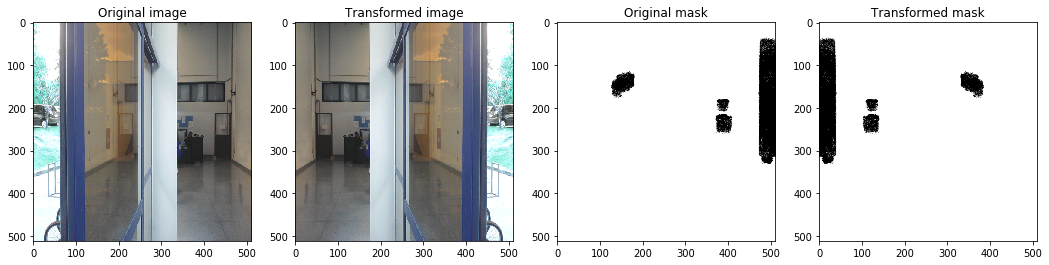

In [0]:
aug = HorizontalFlip(p=1)
augmented = aug(image=image, mask=mask)
image_hflip = augmented['image']
mask_hflip = augmented['mask']
print(image_hflip.shape, mask_hflip.shape)
visualize(image_hflip, mask_hflip, true_image=image, true_mask=mask)

(512, 512, 3) (512, 512, 3)


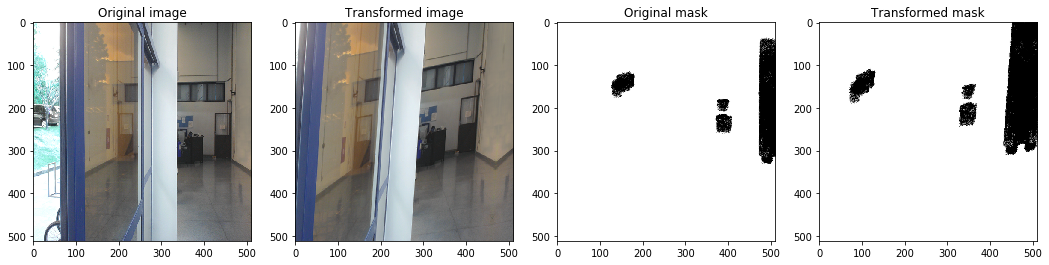

In [0]:
aug = ElasticTransform(p=1,border_mode=cv2.BORDER_REFLECT_101,alpha_affine=80)
augmented = aug(image=image, mask=mask)
image_et = augmented['image']
mask_et = augmented['mask']
print(image_et.shape, mask_et.shape)
visualize(image_et, mask_et, true_image=image, true_mask=mask)

(512, 512, 3) (512, 512, 3)


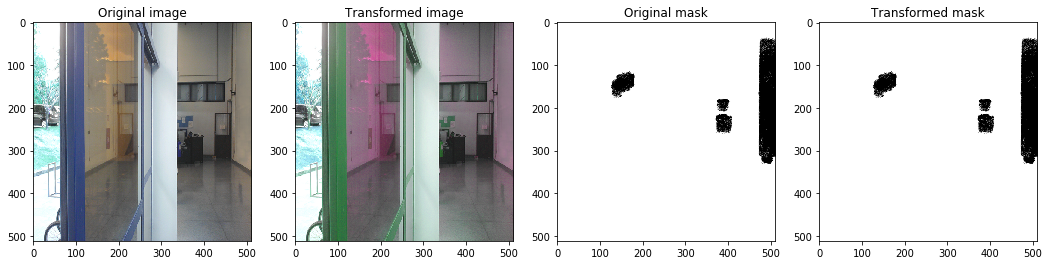

In [0]:
aug = ChannelShuffle(p=1)
augmented = aug(image=image, mask=mask)
image_cs = augmented['image']
mask_cs = augmented['mask']
print(image_cs.shape, mask_cs.shape)
visualize(image_cs, mask_cs, true_image=image, true_mask=mask)

(512, 512, 3) (512, 512, 3)


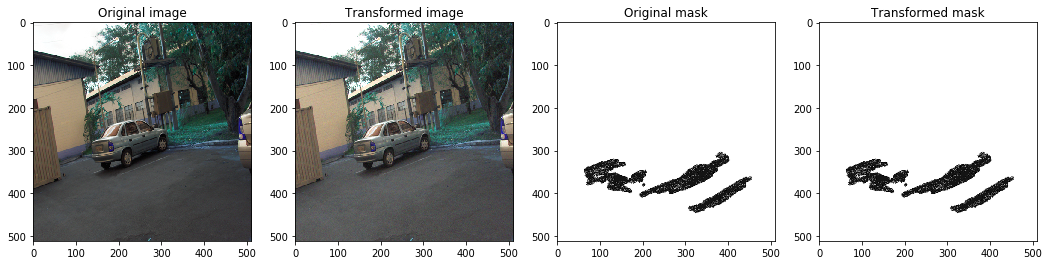

In [0]:
# Composition of augmentations: 

def strong_aug(p=1):
    return Compose([
        RandomRotate90(),
        #Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        #HueSaturationValue(p=0.3),
    ], p=p)

aug = strong_aug(p=1)
augmented = aug(image=image, mask=mask)
image_strong = augmented['image']
mask_strong = augmented['mask']
print(image_strong.shape, mask_strong.shape)
visualize(image_strong, mask_strong, true_image=image, true_mask=mask)

In [0]:
%%time
'''img=Image.open(path+'white_image.png') # manually downloaded
height = 512
width = 512
img = img.resize((height, width), PIL.Image.ANTIALIAS)
img.save(path+'white_img.png')

w=4050
for i in range(1050):
    image=cv2.imread(path+'total_images_512/images/image{}.png'.format(i+450))
   
    mask=cv2.imread(path+'white_img.png')
    img_o=Image.fromarray(image)
    mskh_o=Image.fromarray(mask)
    img_o.save(path+'aug_data_512/images/image{}.png'.format(w))
    mskh_o.save(path+'aug_data_512/masks/mask{}.png'.format(w))
    w=w+1
print("Done!")
'''

Done!
CPU times: user 2min 22s, sys: 1.87 s, total: 2min 23s
Wall time: 2min 45s


In [0]:
path ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'

w=450
for i in range(1050):
    mask=cv2.imread(path+'white_img.png')
    mskh_o=Image.fromarray(mask)
    mskh_o.save(path+'total_images_512/masks/mask{}.png'.format(w))
    w=w+1
print("Done!")

Done!


In [0]:
images_aug_path=path+'aug_data_512/images/'
masks_aug_path=path+'aug_data_512/masks/'

len(os.listdir(images_aug_path)),len(os.listdir(masks_aug_path))

(5100, 5100)

In [0]:
'''images_aug_path='C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training_1/dataset-dist/phase-01/training/aug_data_512/images/'
masks_aug_path='C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training_1/dataset-dist/phase-01/training/aug_data_512/masks/'

len(os.listdir(images_aug_path)),len(os.listdir(masks_aug_path))'''

"images_aug_path='C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training_1/dataset-dist/phase-01/training/aug_data_512/images/'\nmasks_aug_path='C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training_1/dataset-dist/phase-01/training/aug_data_512/masks/'\n\nlen(os.listdir(images_aug_path)),len(os.listdir(masks_aug_path))"

# Error Level Analysis

https://gist.github.com/ewencp/3356622

https://forensics.map-base.info/report_2/index_en.shtml#b

https://fotoforensics.com/tutorial-ela.php

https://www.youtube.com/watch?v=G1Y0UTMTF7o&t=671s

https://29a.ch/photo-forensics/#error-level-analysis  -  Tool to understand how it works


Error Level Analysis is based on characteristics of image formats that are based on lossy image compression. This method can highlight areas of an image which has different degrees of compression. Especially the JPEG format (one of the most popular image formats on the Internet) can be applied particularly well using this method.

For a better understanding it is necessary to know how images in JPEG format are created. JPEG uses a lossy image compression. Each re-encoding process (new saving) performed on the image leads to further loss of quality. The JPEG algorithm is based on a 8x8 pixel grid. Each 8x8 square grid is thereby treated and compressed separately. If the image is untouched, then all these 8x8 squares will show the same error level potential.

If the jpeg image is saved again, then each square should be continuously reduced to approximately the same level. In the ELA process, the original image that is being examined will be resaved at a certain JPEG quality level (for example, at 75%). The resave leads to a known degree of compression, which extends over the entire image. The newly saved image is used to be compared with the original image. The human eye would hardly notice a change. Therefore, the ELA representation will visualize in particular only the difference between the two images. So, the resulting ELA image shows the varying degrees of compression potentials.

![alt text](https://forensics.map-base.info/report_2/grafx/ela_method_en.jpg)

In [0]:
%%time
if not os.path.exists(path+'aug_data_512/ELA_Images'):
    os.makedirs(path+'aug_data_512/ELA_Images')
    
    for file in (os.listdir(path+'aug_data_512/images')):
        filename = path+'aug_data_512/images/{}'.format(file)
        resaved = '.resaved.jpg'
        ela = path+'aug_data_512/ELA_Images/{}'.format(file)
        im = Image.open(filename).convert("RGB")
        im.save(resaved, 'JPEG', quality=95) # try different JPEG quality levels.
        resaved_im = Image.open(resaved)
        ela_im = ImageChops.difference(im, resaved_im)
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0/max_diff
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        ela_im.save(ela)
    print("DONE Converting to ELA!")
else:
    print("Already Exists!")

DONE Converting to ELA!
CPU times: user 15min 48s, sys: 7.71 s, total: 15min 56s
Wall time: 32min 37s


In [0]:
path ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'
images_path = path+'aug_data_512/images/'
masks_path = path+'aug_data_512/masks/'
ela_path = path+'aug_data_512/ELA_Images/'


org_images = os.listdir(images_path)
mask_images = os.listdir(masks_path)
ela_images = os.listdir(ela_path)

len(os.listdir(images_path)),len(os.listdir(masks_path)),len(os.listdir(ela_path))

(5100, 5100, 5100)

# Modelling

<h1>Dice Coefficient : </h1><br/><br/>




![alt text](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

In [0]:
"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal."""

def metric(y_true, y_pred, smooth=1): # Dice_Coeff or F-Score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# UNET 

In image segmentation, we not only need to convert feature map into a vector but also reconstruct an image from this vector. This is a mammoth task because it’s a lot tougher to convert a vector into an image than vice versa. The whole idea of UNet is revolved around this problem.

While converting an image into a vector, we already learned the feature mapping of the image so why not use the same mapping to convert it again to an image.


![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [5]:
# https://github.com/qubvel/segmentation_models

# Unet_ is a fully convolution neural network for image semantic segmentation
#del model
# create model
model = Unet('resnet101', input_shape=(512, 512, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')

# compile keras model with defined optimizer, loss and metrics
model.compile(optimizer=optimizers.Adam(0.00019), loss="binary_crossentropy", metrics=[metric])

#model.summary()
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
'''%%time

path ='/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'

ela_image_files=[]
mask_files=[]
image_files=[]
for i in range(5100):
    imgpath=path+"aug_data_512/images/image{}.png".format(i)
    ela_image_path=path+"aug_data_512/ELA_Images/image{}.png".format(i)
    mask_path=path+"aug_data_512/masks/mask{}.png".format(i)
    image_files.append(imgpath)
    ela_image_files.append(ela_image_path)
    mask_files.append(mask_path)
'''

CPU times: user 9.41 ms, sys: 0 ns, total: 9.41 ms
Wall time: 9.16 ms


# Train Test Split

In [0]:
ela_files = []
mask_files = []
ela_image_files = '/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/'

for i in range(len(os.listdir(ela_image_files))):
  if i<450:
    ela_image_path="/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/image{}.png".format(i)
    mask_path="/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/masks/mask{}.png".format(i)
    ela_files.append(ela_image_path)
    mask_files.append(mask_path)

len(ela_files),len(mask_files)

(450, 450)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(ela_files,mask_files , test_size=0.12, random_state=7)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train , test_size=0.10, random_state=7)

In [0]:
# Composition of augmentations: 

def strong_aug(p=1):
    return Compose([
        RandomRotate90(),
        #Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            #RandomBrightness(),
        ], p=0.3),
        #HueSaturationValue(p=0.3),
    ], p=p)

def aug_with_crop(crop_prob = 1):
    return Compose([
       # RandomCrop(p=crop_prob),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        #RandomGamma(),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
       # HueSaturationValue()
    ], p=p)

def aug_data_1(p=.5):
    return Compose([
        CLAHE(),
        Transpose(),
        Blur(blur_limit=3),
        OpticalDistortion(),
        ElasticTransform(),
        HueSaturationValue()
    ], p=p)

def aug_data_2(p=.5):
    return Compose([
        CLAHE(),
        Blur(blur_limit=3),
        GridDistortion(),
        ElasticTransform(),
        HueSaturationValue()
    ], p=p)

def horizontalFlip(image,mask):
    aug = HorizontalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_hflip = augmented['image']
    mask_hflip = augmented['mask']
    return image_hflip,mask_hflip

def verticalFlip(image,mask):
    aug = VerticalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_vflip = augmented['image']
    mask_vflip = augmented['mask']
    return image_vflip,mask_vflip
    
def randomRotate(image,mask):
    aug = RandomRotate90(p=1)
    augmented = aug(image=image, mask=mask)
    image_rot90 = augmented['image']
    mask_rot90 = augmented['mask']
    return image_rot90,mask_rot90
    
def transpose(image,mask):
    aug = Transpose(p=1)
    augmented = aug(image=image, mask=mask)
    image_transpose = augmented['image']
    mask_transpose = augmented['mask']
    return image_transpose,mask_transpose

def elasticDistortion(image,mask):
    aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
    augmented = aug(image=image, mask=mask)
    image_ed = augmented['image']
    mask_ed = augmented['mask']
    return image_ed,mask_ed

def opticalDistortion(image,mask):
    aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def gridDistortion(image,mask):
    aug = GridDistortion()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def strong_Aug(image,mask):
    aug = strong_aug(p=1)
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def aug_with_Crop(image,mask):
    aug = aug_with_crop()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def augment_flips_Color(image,mask):
    aug = augment_flips_color()
    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']
    #augmented = aug(image=image, mask=mask)
    #image_od = augmented['image']
    #mask_od = augmented['mask']
    return image_od,mask_od

def aug_Data_1(image,mask):
    aug = aug_data_1()
    #augmented = aug(image=image, mask=mask)
    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']
    #image_od = augmented['image']
    #mask_od = augmented['mask']
    return image_od,mask_od

def aug_Data_2(image,mask):
    aug = aug_data_2()
    #augmented = aug(image=image, mask=mask)
    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']
    #image_od = augmented['image']
    #mask_od = augmented['mask']
    return image_od,mask_od

def channelShuffle(image,mask):
    aug = ChannelShuffle(p=1)
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def randomBrightness(image,mask):
    #aug = RandomBrightness(limit=1.2, p=0.5)
    aug = RandomBrightness()
    #augmented = aug(image=image, mask=mask)
    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']
    #image_od = augmented['image']
    #mask_od = augmented['mask']
    return image_od,mask_od

def rotate(image,mask):
    #aug = Rotate(limit=286, p=0.5)
    aug = Rotate()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od
  
def rGBShift(image,mask):
    #aug = RGBShift(r_shift_limit=105, g_shift_limit=45, b_shift_limit=40, p=0.5)
    aug = RGBShift()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def randomGamma(image,mask):
    #aug = RandomGamma(gamma_limit=12, p=0.5)
    aug = RandomGamma()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def flip(image,mask):
    aug = Flip()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def centerCrop(image,mask):
    #aug = CenterCrop(height=288, width=288, p=0.5)
    aug = CenterCrop()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def hueSaturationValue(image,mask):
   # aug = HueSaturationValue(hue_shift_limit=172, sat_shift_limit=20, val_shift_limit=27, p=0.5)
    aug = HueSaturationValue()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od



In [0]:
X_train[1]

'/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/image280.png'

# Augmenting Train Data

In [0]:
import re
train_data = []
mask_data = []
for i in range(len(X_train)):
    #if (int(re.findall('\d+', X_train[i])[2])) < 450:
    train_data.append(X_train[i])
    mask_data.append(y_train[i])

len(train_data),len(mask_data)

(396, 396)

In [0]:
mask_data[0]

'/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/masks/mask109.png'

In [0]:
%%time

path = '/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'

if not os.path.isfile(path+"phase_2"):
    os.makedirs(path+"phase_2/images")
    os.makedirs(path+"phase_2/masks")

w=7000
for i in range(len(train_data)):
  
  image=cv2.imread(train_data[i])
  mask=cv2.imread(mask_data[i])

  

  #actual_image=image.copy()
  #actual_mask=mask.copy()
  img_o=Image.fromarray(image)
  mskh_o=Image.fromarray(mask)
  img_o.save(path+'phase_2/images/image{}.png'.format(w))
  mskh_o.save(path+'phase_2/masks/mask{}.png'.format(w))

  h=horizontalFlip(image,mask)
  imgh=Image.fromarray(h[0])
  mskh=Image.fromarray(h[1])
  imgh.save(path+'phase_2/images/image{}.png'.format(w+1))
  mskh.save(path+'phase_2/masks/mask{}.png'.format(w+1))
  
  v=verticalFlip(image,mask)
  imgv=Image.fromarray(v[0])
  mskv=Image.fromarray(v[1])
  imgv.save(path+'phase_2/images/image{}.png'.format(w+2))
  mskv.save(path+'phase_2/masks/mask{}.png'.format(w+2))
  
  t=transpose(image,mask)
  imgt=Image.fromarray(t[0])
  mskt=Image.fromarray(t[1])
  imgt.save(path+'phase_2/images/image{}.png'.format(w+3))
  mskt.save(path+'phase_2/masks/mask{}.png'.format(w+3))
  
  r=randomRotate(image,mask)
  imgr=Image.fromarray(r[0])
  mskr=im=Image.fromarray(r[1])
  imgr.save(path+'phase_2/images/image{}.png'.format(w+4))
  mskr.save(path+'phase_2/masks/mask{}.png'.format(w+4))
  
  o=opticalDistortion(image,mask)
  imgo=Image.fromarray(o[0])
  msko=Image.fromarray(o[1])
  imgo.save(path+'phase_2/images/image{}.png'.format(w+5))
  msko.save(path+'phase_2/masks/mask{}.png'.format(w+5))
  
  e=elasticDistortion(image,mask)
  imge=Image.fromarray(e[0])
  mske=Image.fromarray(e[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+6))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+6))
  
  s=strong_Aug(image,mask)
  imge=Image.fromarray(s[0])
  mske=Image.fromarray(s[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+7))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+7))
  
  ch=channelShuffle(image,mask)
  imge=Image.fromarray(ch[0])
  mske=Image.fromarray(ch[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+8))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+8))

  ac=aug_with_Crop(image,mask)
  imge=Image.fromarray(ac[0])
  mske=Image.fromarray(ac[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+9))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+9))

  af=augment_flips_Color(image,mask)
  imge=Image.fromarray(af[0])
  mske=Image.fromarray(af[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+10))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+10))

  g=gridDistortion(image,mask)
  imge=Image.fromarray(g[0])
  mske=Image.fromarray(g[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+11))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+11))

  ad=aug_Data_1(image,mask)
  imge=Image.fromarray(ad[0])
  mske=Image.fromarray(ad[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+12))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+12))

  ad2=aug_Data_2(image,mask)
  imge=Image.fromarray(ad2[0])
  mske=Image.fromarray(ad2[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+13))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+13))

##
  hs=hueSaturationValue(image,mask)
  imge=Image.fromarray(hs[0])
  mske=Image.fromarray(hs[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+14))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+14))

  rb=randomBrightness(image,mask)
  imge=Image.fromarray(rb[0])
  mske=Image.fromarray(rb[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+15))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+15))

  r=rotate(image,mask)
  imge=Image.fromarray(r[0])
  mske=Image.fromarray(r[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+16))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+16))

  rgb=rGBShift(image,mask)
  imge=Image.fromarray(rgb[0])
  mske=Image.fromarray(rgb[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+17))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+17))

  rg=randomGamma(image,mask)
  imge=Image.fromarray(rg[0])
  mske=Image.fromarray(rg[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+18))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+18))

  f=flip(image,mask)
  imge=Image.fromarray(f[0])
  mske=Image.fromarray(f[1])
  imge.save(path+'phase_2/images/image{}.png'.format(w+19))
  mske.save(path+'phase_2/masks/mask{}.png'.format(w+19))

 #cc=centerCrop(image,mask)
 #imge=Image.fromarray(cc[0])
 #mske=Image.fromarray(cc[1])
 #imge.save(path+'aug_data_512/images/image{}.png'.format(w+14))
 #mske.save(path+'aug_data_512/masks/mask{}.png'.format(w+14))

  w=w+20  
 

CPU times: user 22min 44s, sys: 43.2 s, total: 23min 27s
Wall time: 30min 44s


In [0]:
images = path+'phase_2/images/'
masks = path+'phase_2/masks/'

train_imgs = []
mask_imgs = []

for i in range(len(os.listdir(images))):
  ela_image_path = path+'phase_2/images/image{}.png'.format(7000+i)
  mask_path = path+'phase_2/masks/mask{}.png'.format(7000+i)
  train_imgs.append(ela_image_path)
  mask_imgs.append(mask_path)

len(train_imgs),len(mask_imgs)

(7920, 7920)

In [0]:
# For Pristine Images

'''ela_image_files = '/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/'

for i in range(len(os.listdir(ela_image_files))):
  if i >= 450:
    ela_image_path="/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/image{}.png".format(i)
    mask_path="/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/masks/mask{}.png".format(i)
    train_imgs.append(ela_image_path)
    mask_imgs.append(mask_path)

len(train_imgs),len(mask_imgs)

'''

(4497, 4497)

In [0]:
import pickle

train_data_path = path+'phase_2/'

with open(train_data_path+'X_train', 'wb') as f:
  pickle.dump(X_train, f)

    
with open(train_data_path+'X_test', 'wb') as f:
  pickle.dump(X_test, f)

with open(train_data_path+'y_train', 'wb') as f:
  pickle.dump(y_train, f)

    
with open(train_data_path+'y_test', 'wb') as f:
   pickle.dump(y_test, f) 

In [0]:
import pickle
path = '/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/'
train_data_path = path+'phase_2/'
 
with open(train_data_path+'X_train', 'rb') as f:
  X_train = pickle.load(f)

with open(train_data_path+'X_test', 'rb') as f:
  X_test = pickle.load(f)

with open(train_data_path+'y_train', 'rb') as f:
  y_train = pickle.load(f)

with open(train_data_path+'y_test', 'rb') as f:
  y_test = pickle.load(f)

In [0]:
print(X_test[5])
print(y_test[5])


/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/ELA_Images/image268.png
/content/drive/My Drive/COLAB FILES/Image Forensics/dataset-dist/phase-01/training/total_images_512/masks/mask268.png


In [0]:
def LoadImages(batch):
    return np.array([resize(imread(file_name), (512, 512, 3))for file_name in batch])

def loadImagesBatchwise(X_train,y_train, batch_size):
    train_image_files=X_train
    train_mask_files=y_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            Y = LoadImages(train_mask_files[batch_start:limit])
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size
 

In [0]:
#tbc=TensorBoardColab()

In [0]:
%%time
#TensorBoardColabCallback(tbc),
batch_size=3
num_training_samples=len(X_train)
num_validation_samples=len(X_test)
num_epochs=20

# define callbacks for learning rate scheduling and best checkpoints saving
filepath = '/content/drive/My Drive/COLAB FILES/Image Forensics/model_seg_wholedata_1.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_metric',save_best_only=True, mode='max')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.22, patience = 1, verbose = 1, min_delta = 0.0001)

# train model
results=model.fit_generator(loadImagesBatchwise(X_train,y_train,batch_size),steps_per_epoch=(num_training_samples // batch_size), epochs=num_epochs,
                            validation_data=loadImagesBatchwise(X_test,y_test,batch_size),validation_steps=num_validation_samples//batch_size,
                         verbose=1,callbacks=[early_stop,reduce_lr,checkpoint])

Epoch 1/20
132/132 [==============================] - 174s 1s/step - loss: 0.3909 - metric: 0.8204 - val_loss: 0.3130 - val_metric: 0.8817
Epoch 2/20
132/132 [==============================] - 163s 1s/step - loss: 0.2608 - metric: 0.9062 - val_loss: 0.2771 - val_metric: 0.9061
Epoch 3/20
132/132 [==============================] - 163s 1s/step - loss: 0.2467 - metric: 0.9247 - val_loss: 0.8833 - val_metric: 0.9444

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.18000013451092e-05.
Epoch 4/20
132/132 [==============================] - 163s 1s/step - loss: 0.2424 - metric: 0.9310 - val_loss: 0.2713 - val_metric: 0.9223
Epoch 5/20
132/132 [==============================] - 163s 1s/step - loss: 0.2402 - metric: 0.9314 - val_loss: 0.2721 - val_metric: 0.9280

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.196000391966663e-06.
Epoch 6/20
132/132 [==============================] - 163s 1s/step - loss: 0.2382 - metric: 0.9317 - val_loss: 0.2741 - val_metric: 0.9249

Epoc

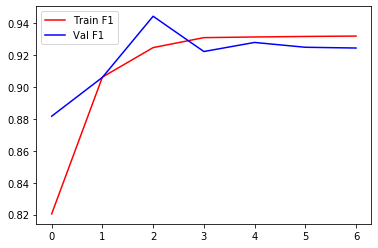

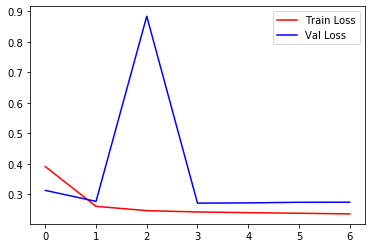

In [0]:
plt.plot(results.history['metric'], 'r')
plt.plot(results.history['val_metric'], 'b')
plt.legend({'Train F1': 'r', 'Val F1':'b'})
plt.show()

# Loss
plt.plot(results.history['loss'], 'r')
plt.plot(results.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Val Loss':'b'})
plt.show()

In [0]:
#Loading Model

filepath = '/content/drive/My Drive/COLAB FILES/Image Forensics/model_seg_wholedata_1.hdf5'
model.load_weights(filepath) # loads the weights of the model from a HDF5 file
test_images=LoadImages(X_test)
y_test_1=LoadImages(y_test)
predicted=model.predict(test_images) # Generates output predictions for the input samples.

# Scores

print("Test-Loss: ",model.evaluate(y_test_1,predicted)[0])
print("Test-Score: ",model.evaluate(y_test_1,predicted)[1])

54/54 [==============================] - 5s 90ms/step
Test-Loss:  0.289031602718212
54/54 [==============================] - 5s 90ms/step
Test-Score:  0.8918683197763231


# Predicting Test Images

In [0]:
filepath = '/content/drive/My Drive/COLAB FILES/Image Forensics/model_seg_wholedata_1.hdf5'
model.load_weights(filepath)
test_images=LoadImages(X_test)
predicted=model.predict(test_images)

In [0]:
def plot_2(image_id):
    ret, bw_img = cv2.threshold((predicted[image_id]*255),220,255,cv2.THRESH_BINARY)
    #cv2_imshow(bw_img)
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(imread(X_test[image_id].replace('ELA_Images','images')))
    #ax[0].imshow(imread(test_images[image_id]))
    ax[0].set_title("IMAGE_{}".format(image_id))
    ax[1].imshow(imread(y_test[image_id]))
    ax[1].set_title('Ground Truth');
    ax[2].imshow(predicted[image_id])
    ax[2].set_title('Predicted');
    ax[3].imshow(bw_img)
    ax[3].set_title('Binary Predicted');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


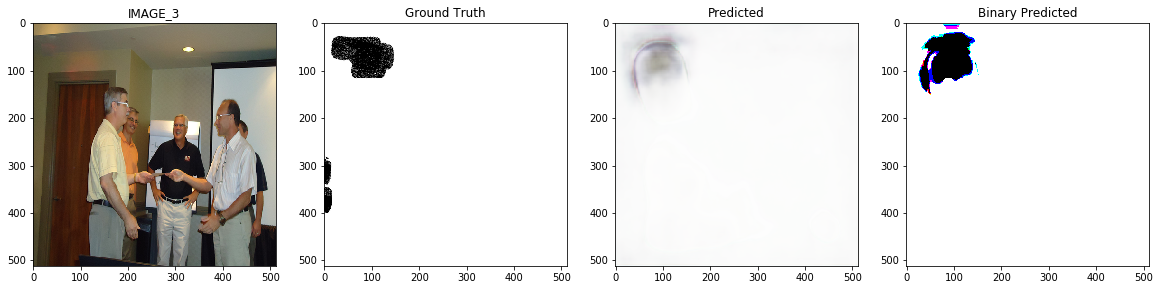

In [141]:
plot_2(3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


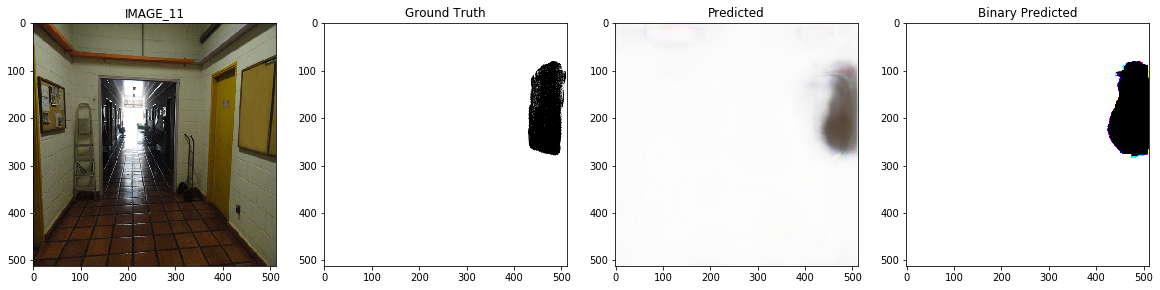

In [142]:
plot_2(11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


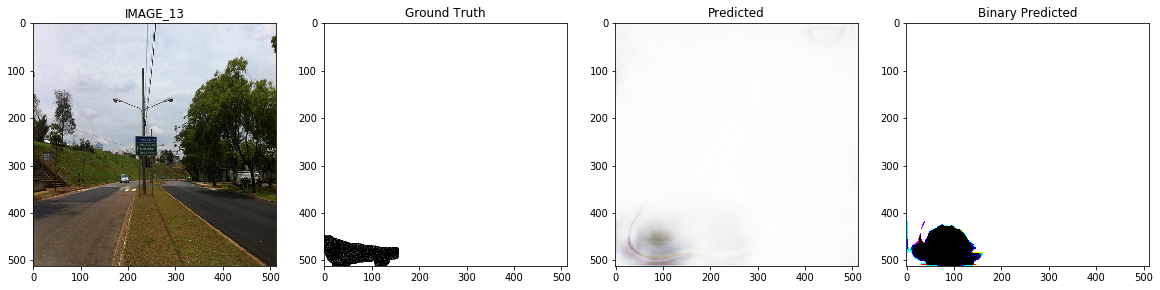

In [143]:
plot_2(13)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


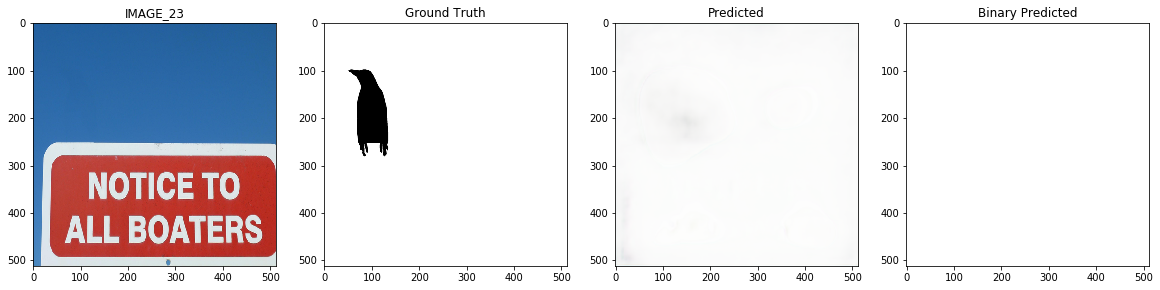

In [140]:
plot_2(23)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


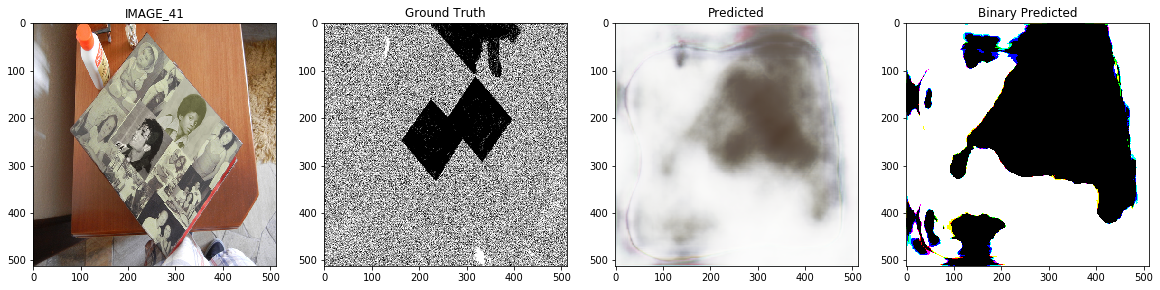

In [138]:
plot_2(41)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


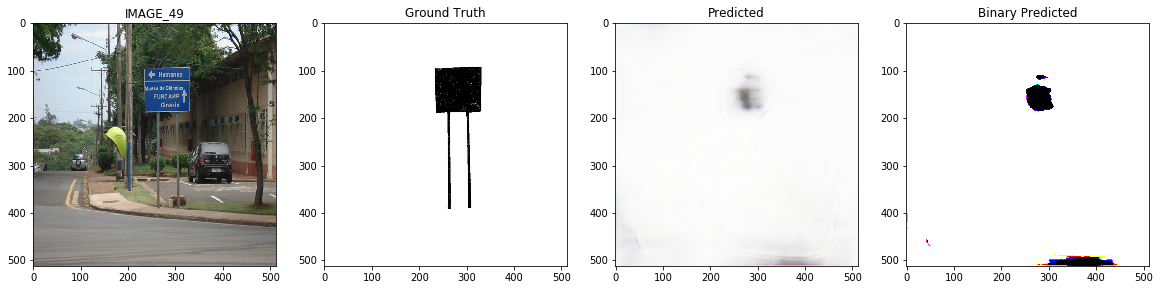

In [147]:
plot_2(49)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


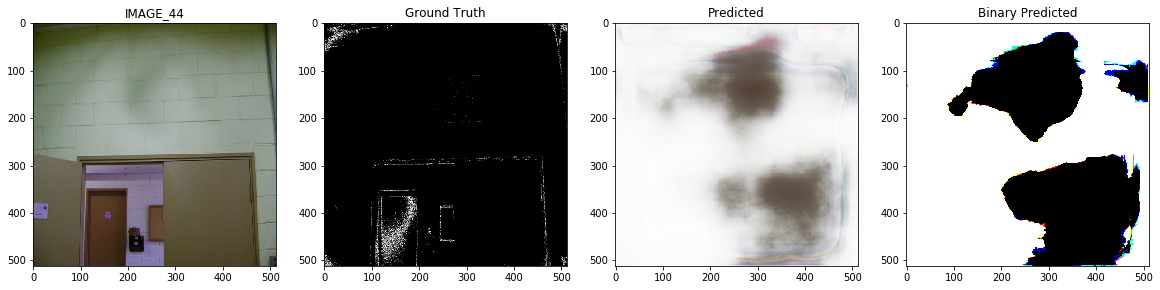

In [137]:
plot_2(44)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


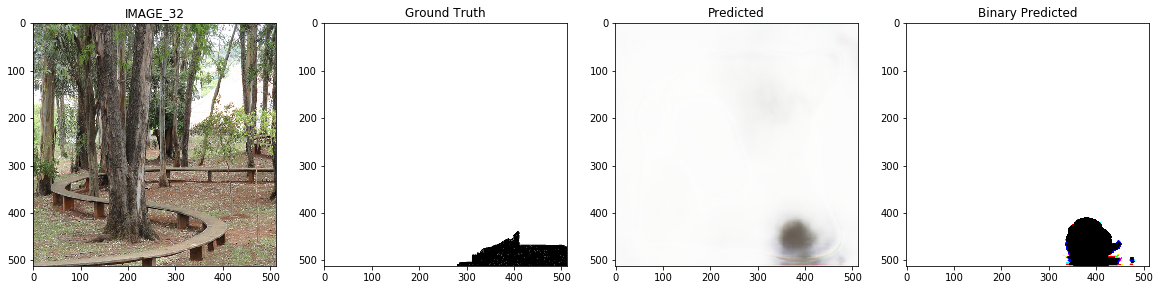

In [146]:
plot_2(32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


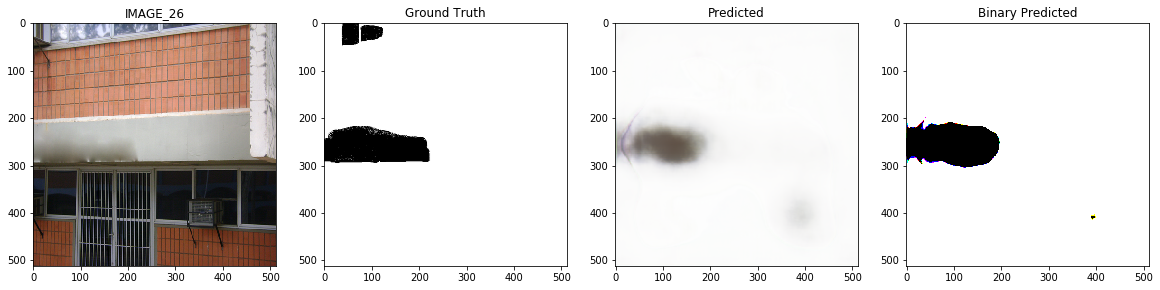

In [139]:
plot_2(26)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


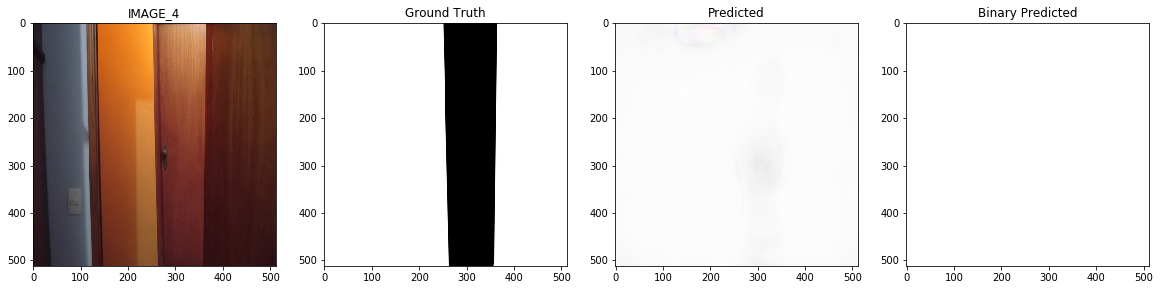

In [144]:
plot_2(4)

In [150]:
'''def plot_1(image_id):
    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(imread(X_test[image_id].replace('ELA_Images','images')))
    #ax[0].imshow(imread(test_images[image_id]))
    ax[0].set_title("IMAGE_{}".format(image_id))
    ax[1].imshow(imread(y_test[image_id]))
    ax[1].set_title('Ground Truth');
    ax[2].imshow(predicted[image_id][:,:,0])
    ax[2].set_title('Predicted_0');
    ax[3].imshow(predicted[image_id][:,:,1])
    ax[3].set_title('Predicted_1');
    ax[4].imshow(predicted[image_id][:,:,2])
    ax[4].set_title('Predicted_2');
'''

'def plot_1(image_id):\n    fig, ax = plt.subplots(1, 5, figsize=(20, 10))\n    ax[0].imshow(imread(X_test[image_id].replace(\'ELA_Images\',\'images\')))\n    #ax[0].imshow(imread(test_images[image_id]))\n    ax[0].set_title("IMAGE_{}".format(image_id))\n    ax[1].imshow(imread(y_test[image_id]))\n    ax[1].set_title(\'Ground Truth\');\n    ax[2].imshow(predicted[image_id][:,:,0])\n    ax[2].set_title(\'Predicted_0\');\n    ax[3].imshow(predicted[image_id][:,:,1])\n    ax[3].set_title(\'Predicted_1\');\n    ax[4].imshow(predicted[image_id][:,:,2])\n    ax[4].set_title(\'Predicted_2\');\n'

In [0]:
# plot_1(16)

In [0]:
# plot_1(23)

#Conclusions:

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Train Score","Test Score"]

x.add_row(["UNET(Resnet50)", 0.93,0.89])

print(x)

+----------------+-------------+------------+
|     Model      | Train Score | Test Score |
+----------------+-------------+------------+
| UNET(Resnet50) |     0.93    |    0.89    |
+----------------+-------------+------------+


Dataset consists of only 1500 images(pristine+fake).

ELA -highlight areas of an image which has different degrees of compression.

We tried to augment the train data using albumentations library.

On top of ELA we used UNET to perform pixel level analysis.

We could see the results are pretty good with Test_Score - 90% (ELA+UNET)

# Below are the ways we can further improve our model.

**Metadata Analysis (EXIF)** -

EXIF stands for Exchangeable Image File Format. Every time you take a picture with your digital camera or phone, a file (typically a JPEG) is written to your device’s storage. In addition to all the bits dedicated to the actual picture, it records a considerable amount of supplemental metadata as well. This can include the date, time, camera settings, and possible copyright information. and also the photo processing software.

**Clone Detection** –
The clone Detection highlights copied regions within an image. These can be a good indicator that a picture has been manipulated.

**Noise Analysis** – 
This is basically a reverse denoising algorithm. Rather than removing the noise, it removes the rest of the image. It is using a super simple separable median filter to isolate the noise. It can be useful for identifying manipulations to the image like airbrushing, deformations, warping, and perspective corrected cloning. It works best on high-quality images.